# Тестовое задание. Построение roll rate и матриц миграции

_Выполнил [Юрий Алексеев](https://tashkent.hh.uz/resume/76f2b01bff0b665d530039ed1f66374e723444)_

_тел. +998971991736_

_https://t.me/Yrius_

##Описание проекта

По условиям задания данные мы генерируем сами. Для рассчетов возьмем портфель из 21000 кредитов. В нашем распоряжении количество кредитов по шести категориям за ноябрь 2022 г. и распределение этих же кредитов по категориями месяц спустя. Часть кредитов осталась в своих категориях, но есть и такие кредиты, которые перетекли как в категорию ближе к дефолтному состоянию, так и в категории более благополучные. Кроме того, мы решили ввести еще одну категорию - кредиты, которые полностью погасили досрочно. Погашенные досрочно кредиты - это недополученная банком прибыль. Данный фактор будет учтен. Считаем, что на момент ноября 2022 г. портфель из 21000 кредитов, данные по которому мы имеем, "прожил" 12 месяцев.

Задача:
1. Построить roll rate (уровни перетока) на основе сравнения данных за ноябрь и декабрь 2022 г.
2. Построить матрицу миграций на весь 2023 г. помесячно.

##Описание данных

Для решения задач будем использовать смоделированный в Excel [дататфрейм](https://docs.google.com/spreadsheets/d/1KFeFdMQM1_KCyXJdPvEz8c76O4cAgfGH/edit?usp=share_link&ouid=107737819750945617634&rtpof=true&sd=true) с синтетическими данными.
Сведения в нем уже сгруппированы по категориям. Однако наличие датафрейма с персональными данными, в которых у каждого кредита или клиента есть свой ID, открывает дополнительные возможности анализа перетока, о которых - в конце работы.

Смоделировать построчные данные с несколькими взаимосвзанными датами событий для каждого клиента не представляется возможным. Поэтому данные сгруппированные.
 
Общее количество кредитов - 21000.
____________________________

Количество кредитов по категориям на ноябрь 2022 г.:

`0 - Нет задолженности` - 11135

`1-30` - 5667

`31-60` - 2774

`61-90` - 1112

`Дефолт (91-∞)` - 312

`Кредит погашен` - 0
_____________________________
Количество оставшихся в категориях кредитов на декабрь 2022 г.:

`0 - Нет задолженности` - 9914

`1-30` - 219

`31-60` - 1000

`61-90` - 932

`Дефолт (91-∞)` - 186

`Кредит погашен` - 272

Остальные перетекли в другие категории.

Данные представлены в абсолютных числах.



##Загрузим датафрейм

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np
import pylab 
import math as mth

import warnings 
warnings.filterwarnings('ignore')

In [2]:
! gdown -- 1KFeFdMQM1_KCyXJdPvEz8c76O4cAgfGH

Downloading...
From: https://drive.google.com/uc?id=1KFeFdMQM1_KCyXJdPvEz8c76O4cAgfGH
To: /content/df_bank_loans.xlsx
100% 9.63k/9.63k [00:00<00:00, 11.8MB/s]


In [3]:
df = pd.read_excel('/content/df_bank_loans.xlsx', sheet_name='Sheet1')

In [4]:
df

,Категория,0 - Нет задолженности,1-30,31-60,61-90,Дефолт (91-∞),Кредит погашен,Всего
0,0 - Нет задолженности,9914,630,356,136,0,99,11135
1,1-30,5300,219,108,23,14,3,5667
2,31-60,1116,418,1000,213,15,12,2774
3,61-90,0,10,12,932,100,58,1112
4,Дефолт (91-∞),0,0,0,26,186,100,312
5,Кредит погашен,0,0,0,0,0,0,0


Вот наш датафрейм. Данные в столбце "Всего" - это распределение кредитов по шести категориям на ноябрь 2022 г. Категории для ноябрьских кредитов расположены в столбе "Категория".

Названия верхних столцов - те же самые категории, но это распределение кредитов по категориям месяц спустя, в декабре 2022 г. Для наглядности подкрасим в датафрейме то количество кредитов в категориях, которое осталось без изменений, в сравнении с ноябрем. 

In [5]:
def highlight_col(x): #функция для закраски столбца
    r = 'background-color: grey'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, 7] = r
    return df1

In [6]:
def highlighter(cell_value): #функция для закраски отдельной ячейки
    if cell_value in [219]:
        return "background-color: grey"

In [7]:
df.style.format().highlight_max(subset=['0 - Нет задолженности', '31-60', '61-90', 'Дефолт (91-∞)'], color='grey').apply(highlight_col, axis=None).applymap(highlighter)

,Категория,0 - Нет задолженности,1-30,31-60,61-90,Дефолт (91-∞),Кредит погашен,Всего
0,0 - Нет задолженности,9914,630,356,136,0,99,11135
1,1-30,5300,219,108,23,14,3,5667
2,31-60,1116,418,1000,213,15,12,2774
3,61-90,0,10,12,932,100,58,1112
4,Дефолт (91-∞),0,0,0,26,186,100,312
5,Кредит погашен,0,0,0,0,0,0,0


Так стало проще читать таш датафрейм. Итак, в категории "Нет задолженности" в ноябре было 11135 кредитов, в декабре осталось 9914 кредитов. Остальные мигрировали в категории просрочки, а 99 кредитов были погашены досрочно.

В категории просрочки "1-30 дней" в ноябре было 5667 кредитов, а в декабре осталось лишь 219. В 5300 кредитов долг был погашен, и теперь эти кредиты мигрировали в категорию "Нет задолженности", 3 кредита были погашены полностью, остальные мигрировали в соседние категории просрочки.

Принцип, как читать таблицу, понятен.

Проверим, совпадает ли количество кредитов за ноябрь с их числом в декабре. 

In [8]:
if df['Всего'].sum()==df.iloc[:, 1:7].sum().sum():
  print('Количество кредитов совпадает. Кредитов в датафрейме -', df['Всего'].sum())
else:
  print('Количество кредитов не совпадает. Кредитов за ноябрь 2022 г. -', df['Всего'].sum(), 'Кредитов за ноябрь - ', df.iloc[:, 1:7].sum().sum()) 


Количество кредитов совпадает. Кредитов в датафрейме - 21000


Все в порядке. Приступим к анализу перетоков.

##Строим roll rate (уровни перетока)

Как следует из академической литературы, roll rate (уровни перетоков) представляет собой упрощенное подмножество более широкого класса моделей — моделей Маркова. Анализ предполагает сравнение категорий кредитов на определенном отрезке времени, например, через месяц, квартал, полугодие; а также расчет доли кредитов, ставших лучше или перешедших в следующие категории просрочки. 
В нашей ситуации мы сравниваем, как поменялось распределение в декабре в сравнении с ноябрем 2022 г. 

Переведем абсолютные числа в относительные и рассмотрим в процентном соотношении, как поменялось распределение по категориям за один месяц.

In [9]:
roll_rate = df['Категория'].reset_index().drop('index', axis=1).copy()

In [10]:
roll_rate['0 - Нет задолженности, %'] = df['0 - Нет задолженности'] / df['Всего'] * 100
roll_rate['1-30, %'] = df['1-30'] / df['Всего'] * 100
roll_rate['31-60, %'] = df['31-60'] / df['Всего'] * 100
roll_rate['61-90, %'] = df['61-90'] / df['Всего'] * 100
roll_rate['Дефолт (91-∞), %'] = df['Дефолт (91-∞)'] / df['Всего'] * 100
roll_rate['Кредит погашен, %'] = df['Кредит погашен'] / df['Всего'] * 100

roll_rate = roll_rate.fillna(0) #заполнили ячейки с nan в нижней строке нулями

Подкрасим доли оставшихся в категориях кредитов в сравнении с предыдущим месяцем.

In [11]:
def highlighter(cell_value): 
    if cell_value in [roll_rate.loc[0][1],
                      roll_rate.loc[1][2],
                      roll_rate.loc[2][3],
                      roll_rate.loc[3][4],
                      roll_rate.loc[4][5]]:
        return "background-color: grey"

In [12]:
roll_rate.style.format().applymap(highlighter)

,Категория,"0 - Нет задолженности, %","1-30, %","31-60, %","61-90, %","Дефолт (91-∞), %","Кредит погашен, %"
0,0 - Нет задолженности,89.034576,5.657836,3.197126,1.221374,0.000000,0.889088
1,1-30,93.523910,3.864479,1.905770,0.405858,0.247044,0.052938
2,31-60,40.230714,15.068493,36.049027,7.678443,0.540735,0.432588
3,61-90,0.000000,0.899281,1.079137,83.812950,8.992806,5.215827
4,Дефолт (91-∞),0.000000,0.000000,0.000000,8.333333,59.615385,32.051282
5,Кредит погашен,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Больше всего кредитов не мигрировали в другие в самой благополучной категории "Нет задолженности" (89% от ноябрьских) и "61-90" дней просрочки. Сильнее всего миграция в категории "1-30" дней просрочки. 93% кредитов из этой категории мигрировали в более благополучную "Нет задолженности", долг по ним был оплачен. 

Попробуем визуализировать переток кредитов по категориям на момент декабря 2022 г. в сравнении с предыдущим месяцем.

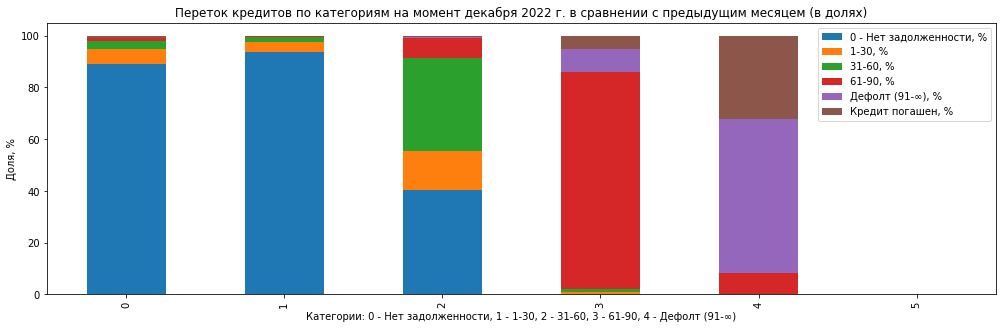

In [13]:
roll_rate.plot.bar(stacked=True, figsize=(17, 5))
plt.title('Переток кредитов по категориям на момент декабря 2022 г. в сравнении с предыдущим месяцем (в долях)')
plt.xlabel('Категории: 0 - Нет задолженности, 1 - 1-30, 2 - 31-60, 3 - 61-90, 4 - Дефолт (91-∞)')
plt.ylabel('Доля, %');

Еще один вариант визуализации, чтобы видеть нагляднее, в какие категории перетекали или остались без дмижения кредиты в декабре в сравнении с ноябрем:

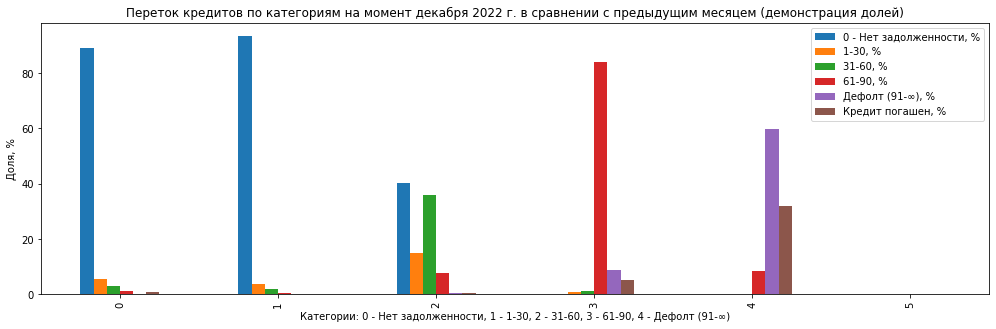

In [14]:
roll_rate.plot(kind='bar', figsize=(17, 5))
plt.title('Переток кредитов по категориям на момент декабря 2022 г. в сравнении с предыдущим месяцем (демонстрация долей)')
plt.xlabel('Категории: 0 - Нет задолженности, 1 - 1-30, 2 - 31-60, 3 - 61-90, 4 - Дефолт (91-∞)')
plt.ylabel('Доля, %');

Рассчитаем, какая доля кредитов в категориях в декабре, в сравнении с ноябрем, осталась в тех же категориях; какая мигрировала в сторону улучшения категории, а какая перетекла в более близкие к дефолту категории.

In [15]:
roll_rate_total = df['Категория'].reset_index().drop('index', axis=1).copy()

roll_rate_total['Переток назад, %'] = 0.0
roll_rate_total['Без изменений, %'] = roll_rate.loc[0][1]
roll_rate_total['Переток в сторону дефолта, %'] = roll_rate.iloc[:1, 2:7].sum(axis=1)

roll_rate_total['Без изменений, %'][1] = roll_rate.loc[1][2]
roll_rate_total['Без изменений, %'][2] = roll_rate.loc[2][3]
roll_rate_total['Без изменений, %'][3] = roll_rate.loc[3][4]
roll_rate_total['Без изменений, %'][4] = roll_rate.loc[4][5]

roll_rate_total['Переток в сторону дефолта, %'][1] = roll_rate.iloc[1:2, 3:7].sum(axis=1)
roll_rate_total['Переток в сторону дефолта, %'][2] = roll_rate.iloc[2:3, 4:7].sum(axis=1)
roll_rate_total['Переток в сторону дефолта, %'][3] = roll_rate.iloc[3:4, 5:7].sum(axis=1)
roll_rate_total['Переток в сторону дефолта, %'][4] = roll_rate.iloc[4:5, 6:7].sum(axis=1)

roll_rate_total['Переток назад, %'][1] = roll_rate.loc[1][1]
roll_rate_total['Переток назад, %'][2] = roll_rate.iloc[2:3, 1:3].sum(axis=1)
roll_rate_total['Переток назад, %'][3] = roll_rate.iloc[3:4, 1:4].sum(axis=1)
roll_rate_total['Переток назад, %'][4] = roll_rate.iloc[4:5, 1:5].sum(axis=1)

roll_rate_total = roll_rate_total.fillna(0)

roll_rate_total

,Категория,"Переток назад, %","Без изменений, %","Переток в сторону дефолта, %"
0,0 - Нет задолженности,0.000000,89.034576,10.965424
1,1-30,93.523910,3.864479,2.611611
2,31-60,55.299207,36.049027,8.651766
3,61-90,1.978417,83.812950,14.208633
4,Дефолт (91-∞),8.333333,59.615385,32.051282
5,Кредит погашен,0.000000,89.034576,0.000000


Визуализируем данные.

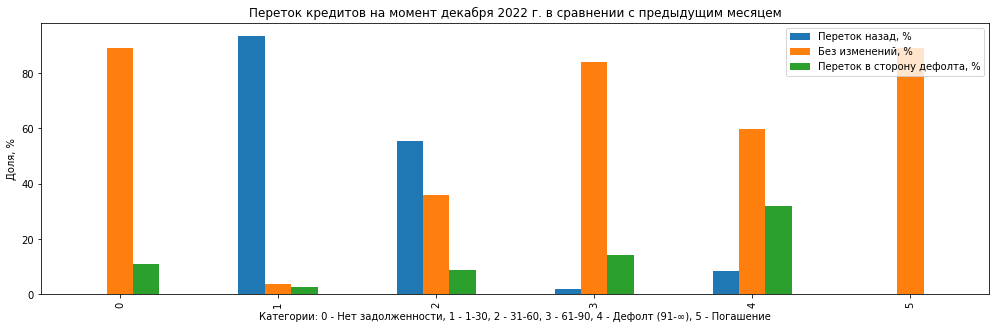

In [16]:
roll_rate_total.plot(kind='bar', figsize=(17, 5))
plt.title('Переток кредитов на момент декабря 2022 г. в сравнении с предыдущим месяцем')
plt.xlabel('Категории: 0 - Нет задолженности, 1 - 1-30, 2 - 31-60, 3 - 61-90, 4 - Дефолт (91-∞), 5 - Погашение')
plt.ylabel('Доля, %');

Теперь сразу видно, какая доля кредитов осталась в своих категориях в декабре (желтые столбцы), какая мигрировала в более благополучные категории (обощенные данные, синие столбцы), а какая переместилась в более рискованные категории (зеленые столбцы).

Предложим еще один график. Данные на нем те же. График позволяет нагляднее увидеть движение перетоков в категориях.

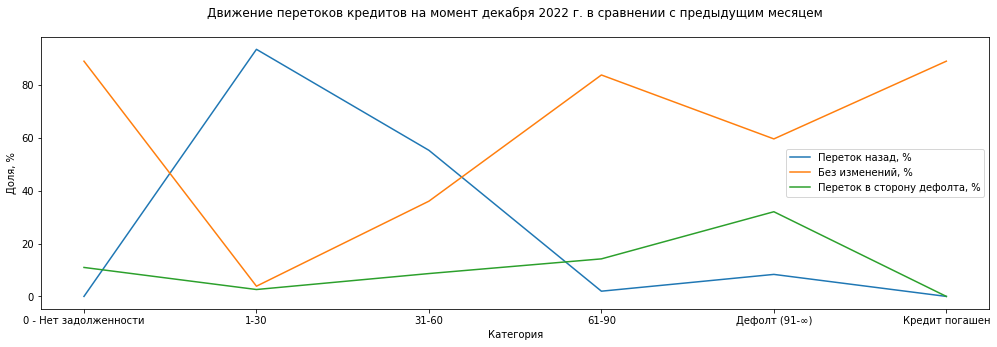

In [17]:
plt.figure(figsize=(17, 5))

plt.plot(roll_rate_total['Категория'], roll_rate_total['Переток назад, %'])
plt.plot(roll_rate_total['Категория'], roll_rate_total['Без изменений, %'])
plt.plot(roll_rate_total['Категория'], roll_rate_total['Переток в сторону дефолта, %'])

plt.title('Движение перетоков кредитов на момент декабря 2022 г. в сравнении с предыдущим месяцем', pad=20)
plt.xlabel('Категория')
plt.ylabel('Доля, %')
plt.legend(['Переток назад, %', 'Без изменений, %', 'Переток в сторону дефолта, %'])

plt.show()

Промежуточный вывод:
Больше 60% кредитов остаются в своих категориях, за исключением категорий просрочки "1-30" и "31-60" дней. Однако в этих категориях сильнее всего доля перетока назад, в более благополучные категории. 

##Строим матрицы миграций

Матрица миграции - это оценка вероятности перехода кредита из одной категории в
другую или наступления дефолта, либо погашения кредита в течение определенного промежутка времени. В нашем распоряжении данные за месяц и задача спрогнозировать вероятность миграции кредитов по категориям на год вперед. Если roll rate показал фактические перетоки, матрица миграции рассчитывает вероятности развития событий на основе имеющихся наблюдений.

Отметим, что упомянутые выше цепи Маркова, к которым относится и построение матриц миграции, учитывают фактическое нахождение кредита в той или иной категории в момент времени и не берет в рассчет такие особенности, как информацию о заемщиках, бизнес-среде, успешности обслуживания кредитов в более ранние периоды. 

Для построения матриц миграции, то есть прогноза сохранения кредитов в их категориях, необходимо перевести датафрейм в массив, из которого построим квадратную матрицу.

Прогноз рассчитывается путем возведения матрицы в степень. Прогноз на месяц? Тогда матрицу нужно возвести в квадрат. На два месяца? Тогда в куб. Наша задача - построить прогноз на год, следовательно, будем возводить матрицу в 13-ю степень.

In [18]:
roll_rate.iloc[:, 1:7] / 100 #переводим проценты в доли для точности рассчетов

,"0 - Нет задолженности, %","1-30, %","31-60, %","61-90, %","Дефолт (91-∞), %","Кредит погашен, %"
0,0.890346,0.056578,0.031971,0.012214,0.000000,0.008891
1,0.935239,0.038645,0.019058,0.004059,0.002470,0.000529
2,0.402307,0.150685,0.360490,0.076784,0.005407,0.004326
3,0.000000,0.008993,0.010791,0.838129,0.089928,0.052158
4,0.000000,0.000000,0.000000,0.083333,0.596154,0.320513
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
numpy_array = (roll_rate.iloc[:, 1:7] / 100).to_numpy()
numpy_array = numpy_array.reshape(6,6) #проверяем, чтобы матрица была квадратной, размером 6*6

In [20]:
table_columns = [
    '0, %',
    '1-30, %',
    '31-60, %',
    '61-90, %',
    'Дефолт, %',
    'Погашение, %'
]

В Excel для возведения матрицы в степень используют формулу MMULT. В Python для этого есть функция `np.linalg.matrix_power(A, P)`, где А – матрица, P – степень. Напишем цикл, чтобы видеть, какие результаты прогнозируются на каждый месяц для нашего кредитного портфеля.

In [21]:
for degree in range(2,14):
    print(f"Месяц {degree - 1}:")
    result = np.linalg.matrix_power(numpy_array, degree)    
    result_dataframe = pd.DataFrame(result, columns=table_columns, index=table_columns)
    result_dataframe = result_dataframe * 100
    display(result_dataframe)
    print()

Месяц 1:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",85.849212,5.748818,4.120086,2.379567,0.141101,0.872126
"1-30, %",87.649533,5.731592,3.755117,1.665044,0.203627,0.942150
"31-60, %",64.414670,8.359602,14.651582,9.801119,1.245025,1.095414
"61-90, %",1.275187,0.951076,1.310613,71.082016,12.906288,7.258993
"Дефолт, %",0.000000,0.074940,0.089928,11.952361,36.289341,19.542147
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Месяц 2:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",83.469542,5.721603,4.365197,3.394374,0.334589,0.953481
"1-30, %",84.909509,5.761376,4.283148,2.794616,0.305592,0.950671
"31-60, %",71.063991,6.263443,7.606253,10.264044,1.723500,1.550766
"61-90, %",2.552109,0.945618,1.298430,60.771528,14.095838,7.861657
"Дефолт, %",0.106266,0.123932,0.162829,13.048947,22.709554,12.255042
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Месяц 3:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",81.423969,5.631974,4.387908,4.250684,0.542455,1.048315
"1-30, %",82.710226,5.697225,4.398654,3.757041,0.470888,1.020207
"31-60, %",72.189390,5.501184,5.244116,10.223643,2.007100,1.755800
"61-90, %",3.679007,0.923098,1.223495,52.243771,13.877710,7.716443
"Дефолт, %",0.276026,0.152684,0.205273,12.843474,14.713041,7.961029
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Месяц 4:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",79.528014,5.523898,4.338228,4.962100,0.743283,1.141466
"1-30, %",80.738576,5.596374,4.379142,4.559200,0.656445,1.104297
"31-60, %",71.528184,5.179098,4.413606,10.042691,2.157880,1.843974
"61-90, %",4.631126,0.898005,1.140054,45.086148,12.980328,7.211420
"Дефолт, %",0.471138,0.167948,0.224332,12.010334,9.927712,5.389035
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Месяц 5:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",77.718896,5.411363,4.265321,5.547685,0.926448,1.225812
"1-30, %",78.880956,5.485197,4.315806,5.220987,0.838847,1.187943
"31-60, %",70.304135,5.002468,4.084984,9.830441,2.226209,1.873221
"61-90, %",5.421805,0.873965,1.062696,39.017471,11.801165,6.558559
"Дефолт, %",0.666798,0.174957,0.228741,10.917186,7.000138,3.813645
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Месяц 6:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",75.973576,5.298937,4.185373,6.025593,1.087630,1.298602
"1-30, %",77.097575,5.372207,4.238607,5.762847,1.006483,1.264074
"31-60, %",68.916910,4.874961,3.921728,9.617343,2.245643,1.871653
"61-90, %",6.072177,0.851540,0.994141,33.836490,10.551981,5.870773
"Дефолт, %",0.849331,0.177131,0.224923,9.759778,5.156589,2.820066
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Месяц 7:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",74.282330,5.188096,4.103767,6.411663,1.225987,1.359267
"1-30, %",75.373019,5.260180,4.157454,6.202798,1.154452,1.329816
"31-60, %",67.496871,4.765030,3.813795,9.410362,2.236867,1.853659
"61-90, %",6.602681,0.830548,0.933884,29.392646,9.340933,5.205636
"Дефолт, %",1.012347,0.176559,0.216934,8.638037,3.953452,2.170424
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Месяц 8:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",72.640042,5.079300,4.022332,6.719396,1.342473,1.408300
"1-30, %",73.700147,5.150006,4.075676,6.556116,1.281512,1.384446
"31-60, %",66.086312,4.662313,3.725157,9.210076,2.212167,1.826900
"61-90, %",7.031138,0.810710,0.880767,25.568977,8.218958,4.590142
"Дефолт, %",1.153738,0.174469,0.207150,7.598986,3.135277,1.727710
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Месяц 9:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",71.043326,4.972674,3.941717,6.960271,1.438881,1.446675
"1-30, %",72.074774,5.041955,3.994425,6.835671,1.388319,1.428313
"31-60, %",64.698702,4.563379,3.643988,9.015701,2.178697,1.795558
"61-90, %",7.372690,0.791795,0.833677,22.271823,7.205898,4.034668
"Дефолт, %",1.273733,0.171569,0.196890,6.660913,2.554021,1.412493
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Месяц 10:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",69.489543,4.868232,3.862174,7.144064,1.517317,1.475537
"1-30, %",70.493889,4.936089,3.914127,7.052346,1.476425,1.462268
"31-60, %",63.338067,4.467068,3.566381,8.826419,2.140581,1.761952
"61-90, %",7.640156,0.773642,0.791680,19.424438,6.305149,3.540818
"Дефолт, %",1.373732,0.168265,0.186850,5.826914,2.123081,1.178285
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Месяц 11:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",67.976461,4.765953,3.783816,7.279134,1.579917,1.496050
"1-30, %",68.955039,4.832403,3.834958,7.215386,1.547740,1.487350
"31-60, %",62.005336,4.372967,3.491025,8.641631,2.100179,1.727378
"61-90, %",7.844419,0.756139,0.754018,16.962867,5.511833,3.105788
"Дефолт, %",1.455635,0.164782,0.177365,5.092440,1.791112,0.997507
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Месяц 12:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",66.502115,4.665800,3.706702,7.372645,1.628706,1.509313
"1-30, %",67.456110,4.730867,3.757003,7.332683,1.604232,1.504632
"31-60, %",60.700421,4.280910,3.417463,8.460942,2.058835,1.692566
"61-90, %",7.994763,0.739208,0.720075,14.833174,4.817284,2.724773
"Дефолт, %",1.521484,0.161247,0.168571,4.449450,1.527098,0.853484
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


12 матриц миграции с прогнозом на год готовы. Так, к 12-му месяцу вероятность того, что клиенты, у которых не было в предыдущем месяце задолженности, останутся в категории "Нет задолженности", составляет 66,5%. Напомним, на декабрь 2022, согласно имеющимся данным, эта вероятность равнялась 89%. 

Найдем средние значения вероятностей для каждой категории на каждый месяц прогноза, чтобы визуализировать тенденции.

In [22]:
result = np.linalg.matrix_power(numpy_array, 2)    
result_dataframe = pd.DataFrame(result, columns=table_columns, index=table_columns)
result_dataframe = result_dataframe * 100
migration_matrix_avg = result_dataframe.describe().iloc[1:2,:] 

In [23]:
#прогоняем через цикл наши матрицы и забираем данные средних величин для каждого столбца в каждый из 12 месяцев
for degree in range(3,14):
    result = np.linalg.matrix_power(numpy_array, degree)    
    result_dataframe = pd.DataFrame(result, columns=table_columns, index=table_columns)
    result_dataframe = result_dataframe * 100
    migration_matrix_avg = migration_matrix_avg.append((result_dataframe.describe().iloc[1:2,:]), ignore_index=True)    
                                                                                                         

In [24]:
months = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']

In [25]:
migration_matrix_avg['Месяц'] = months

In [26]:
migration_matrix_avg

,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %",Месяц
0,39.864767,3.477671,3.987888,16.146684,8.464230,4.951805,январь
1,40.350236,3.135995,2.952643,15.045585,6.528179,3.928603,февраль
2,40.046436,2.984361,2.576574,13.886436,5.268532,3.250299,март
3,39.482840,2.894220,2.415894,12.776745,4.410941,2.781699,апрель
4,38.832098,2.824658,2.326258,11.755628,3.798801,2.443197,май
5,38.151595,2.762463,2.260795,10.833675,3.341388,2.187528,июнь
6,37.461208,2.703402,2.204306,10.009251,2.985282,1.986467,июль
7,36.768563,2.646133,2.151847,9.275592,2.698398,1.822916,август
8,36.077204,2.590229,2.101783,8.624063,2.460969,1.686284,сентябрь
9,35.389231,2.535549,2.053535,8.045697,2.260426,1.569810,октябрь


##Визуализируем усредненные данные из матриц миграций

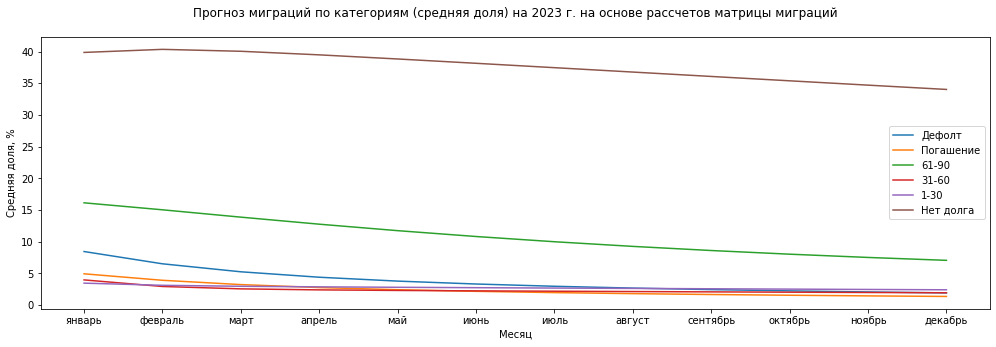

In [27]:
plt.figure(figsize=(17, 5))

plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['Дефолт, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['Погашение, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['61-90, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['31-60, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['1-30, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['0, %'])

plt.title('Прогноз миграций по категориям (средняя доля) на 2023 г. на основе рассчетов матрицы миграций', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Средняя доля, %')
plt.legend(['Дефолт', 'Погашение', '61-90', '31-60', '1-30', 'Нет долга'])

plt.show()

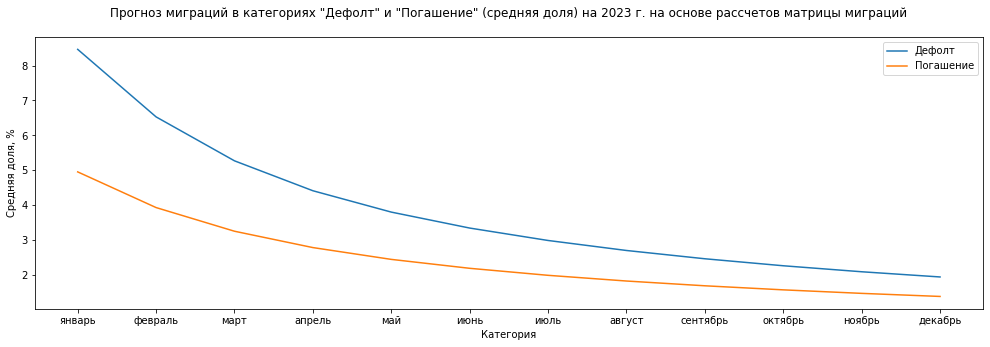

In [28]:
plt.figure(figsize=(17, 5))

plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['Дефолт, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['Погашение, %'])

plt.title('Прогноз миграций в категориях "Дефолт" и "Погашение" (средняя доля) на 2023 г. на основе рассчетов матрицы миграций', pad=20)
plt.xlabel('Категория')
plt.ylabel('Средняя доля, %')
plt.legend(['Дефолт', 'Погашение'])

plt.show()

##Общий вывод

- roll rate показал, что больше 60% кредитов остаются в своих категориях за месяц наблюдений, за исключением категорий просрочки "1-30" и "31-60" дней. Однако в этих категориях сильнее всего доля перетока назад, в более благополучные категории. 
- Судя по кривым жизненного цикла нашего кредитного портфеля на ближайший год, заметны тенденции снижения вероятностей дефолта и досрочного погашения.
- Вероятность, что кредит из категории "Нет задолженности", останется в ней же, за 12 месяц снизилась на 5 п.п.
- Кривые вероятностей на графике с диапазоном в год имеют нисходящий вид. Академическая литература подтверждает, что "подход, основанный на
матрицах миграции, не демонстрирует высокой точности при длительных горизонтах, а также нуждается в дополнительных допущениях, связанных с вопросом учета случаев реструктуризации задолженности".
- Чтобы проверить точность рассчетов, я частично перепроверил их в Excel, при работе с небольшими таблицами он удобнее, но когда данных много, конечно, нужен Phyton. [Вот](https://docs.google.com/spreadsheets/d/1U0H6eRFEO-uePM6cEbrE9SyF-0pRlKjbZdlVzeB1tYs/edit?usp=sharing) ссылка на рассчеты в Excel для проверки.

##Рекомендации


- Синтетические данные ограничены. Датафреймов, подходящих для нашего исследования, я не нашел. В Kaggle много датафреймов для оценки платежеспособности потенциальных клиентов банка, но нам нужны данные другого типа. С датами, когда был взят кредит, датами плановых и фактических платежей. Это нужно, чтоб можно было формировать когорты и корректно их сегментировать для дальнейшего исследования.
- Если бы были данные, привязанные к уникальным клиентам или кредитам, можно было бы строить диаграммы перетока. Мы сможем увидеть судьбу каждого кредита в портфеле. Эти диаграммы могут с легкостью заменить roll rate, потому как более наглядные.
[Вот](https://ft-interactive.github.io/visual-vocabulary/) пример (вкладка Flow). Или [вот](https://github.com/open-risk/transitionMatrix/blob/master/examples/sankey.png) более детальный переток конкретной категории.

Пример sunkey для Python:

In [29]:
import plotly.graph_objects as go
import urllib, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())

# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
                                    for src in data['data'][0]['link']['source']]

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    valuesuffix = "TWh",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['data'][0]['node']['label'],
      color =  data['data'][0]['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['data'][0]['link']['source'],
      target =  data['data'][0]['link']['target'],
      value =  data['data'][0]['link']['value'],
      label =  data['data'][0]['link']['label'],
      color =  data['data'][0]['link']['color']
))])

fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
                  font_size=10)
fig.show()